In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [6]:
data = pd.read_csv('DBtrainrides.csv', encoding='UTF-8')

In [3]:
data.head()

,ID,line,path,eva_nr,category,station,state,city,zip,long,lat,arrival_plan,departure_plan,arrival_change,departure_change,arrival_delay_m,departure_delay_m,info,arrival_delay_check,departure_delay_check
0,1573967790757085557-2407072312-14,20,Stolberg(Rheinl)Hbf Gl.44|Eschweiler-St.Jöris|...,8000001,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,52064,6.091499,50.767800,2024-07-08 00:00:00,2024-07-08 00:01:00,2024-07-08 00:03:00,2024-07-08 00:04:00,3,3,NaN,on_time,on_time
1,349781417030375472-2407080017-1,18,NaN,8000001,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,52064,6.091499,50.767800,NaN,2024-07-08 00:17:00,NaN,NaN,0,0,NaN,on_time,on_time
2,7157250219775883918-2407072120-25,1,Hamm(Westf)Hbf|Kamen|Kamen-Methler|Dortmund-Ku...,8000406,4,Aachen-Rothe Erde,Nordrhein-Westfalen,Aachen,52066,6.116475,50.770202,2024-07-08 00:03:00,2024-07-08 00:04:00,2024-07-08 00:03:00,2024-07-08 00:04:00,0,0,NaN,on_time,on_time
3,349781417030375472-2407080017-2,18,Aachen Hbf,8000404,5,Aachen West,Nordrhein-Westfalen,Aachen,52072,6.070715,50.780360,2024-07-08 00:20:00,2024-07-08 00:21:00,NaN,NaN,0,0,NaN,on_time,on_time
4,1983158592123451570-2407080010-3,33,Herzogenrath|Kohlscheid,8000404,5,Aachen West,Nordrhein-Westfalen,Aachen,52072,6.070715,50.780360,2024-07-08 00:20:00,2024-07-08 00:21:00,2024-07-08 00:20:00,2024-07-08 00:21:00,0,0,NaN,on_time,on_time


## Data transformation

Cleaning path column

In [7]:
def clean_station_name(station: str) -> str:
    """Clean one station name: remove hyphens, brackets, and trim spaces."""
    station = station.replace('-', ' ')       # replace hyphens with spaces
    station = station.replace('(', ' ')    # replace brackets with spaces
    station = station.replace(')', ' ')    # replace brackets with spaces
    station = station.replace('Hauptbahnhof', 'Hbf')
    station = re.sub(r'\s+', ' ', station)
    return station.strip()

def clean_path(path: str) -> str:
    """Clean a full path, applying cleaning per station."""
    if not isinstance(path, str) or not path.strip():
        return ''
    stations = path.split('|')
    cleaned = [clean_station_name(s) for s in stations]
    return '|'.join(cleaned)

# Apply cleaning
data['path'] = data['path'].apply(clean_path)


Cleaning station column

In [8]:
data['station'] = data['station'].apply(clean_station_name)

Line types distribution before corrections

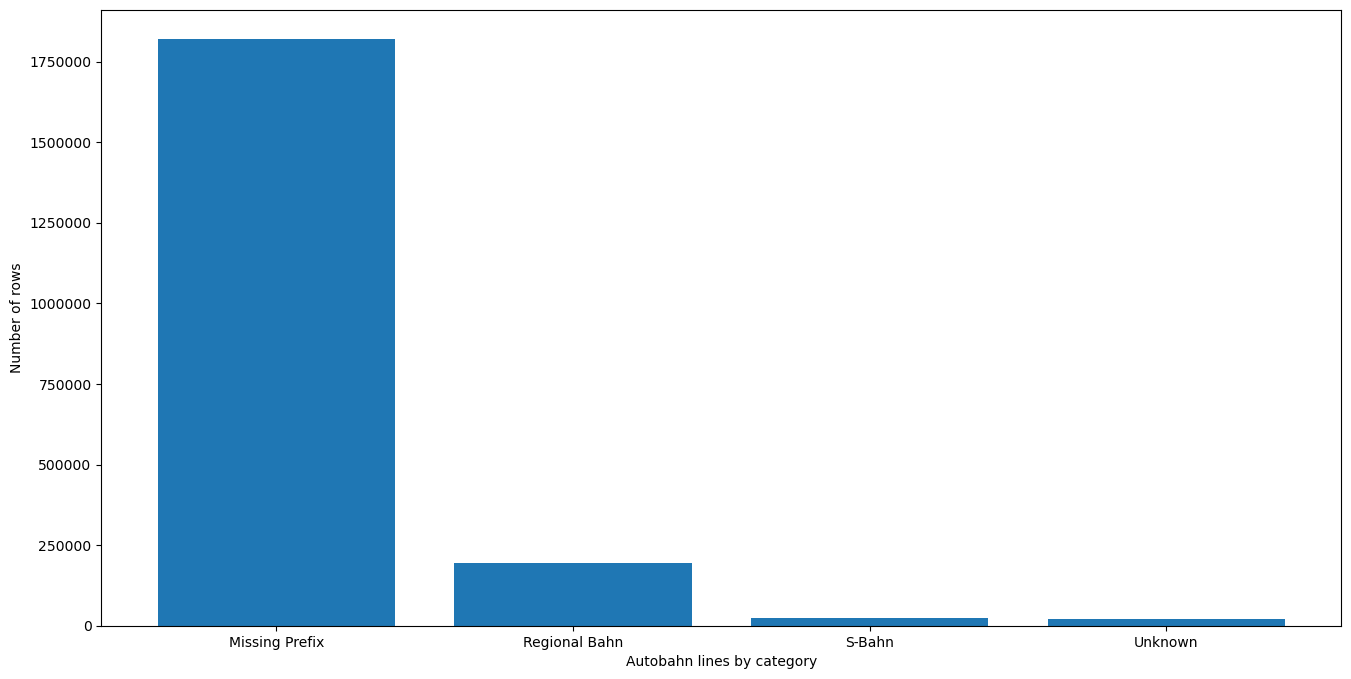

In [ ]:
lines = data['line'].dropna().astype(str)
def classify_line(line):
    if pd.isna(line):
        return None
    line = str(line).upper().strip()

    if re.match(r'^(ICE|IC|EC)', line):
        return 'Long Distance'
    elif re.match(r'^(RE|IRE|RB|RS|C)', line):
        return 'Regional Bahn'
    elif re.match(r'^S', line):
        return 'S-Bahn'
    elif re.match(r'^\d+[A-Z]?$' , line):  # e.g. 10, 10B, 25A
        return 'Missing Prefix'
    else:
        return 'Other'

counts =lines.apply(classify_line).value_counts().sort_index()

plt.figure(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')
plt.bar(counts.index, counts.values)
plt.xlabel("Autobahn lines by category")
plt.ylabel("Number of rows")
plt.show()

Adding the correct prefix to line

In [18]:
mapping = pd.read_csv("../lines/correct_line_mapping.csv")

In [20]:
def get_fixed_line(row):
    matches = mapping[
        mapping['full_path'].str.contains(row['path'], na=False, regex=False) &
        (mapping['line'] == row['line'])
    ]['fixed_line'].unique()

    # Return first match if any
    return matches[0] if len(matches) > 0 else row['line']

data['line'] = data.apply(get_fixed_line, axis=1)


Line types distribution after corrections

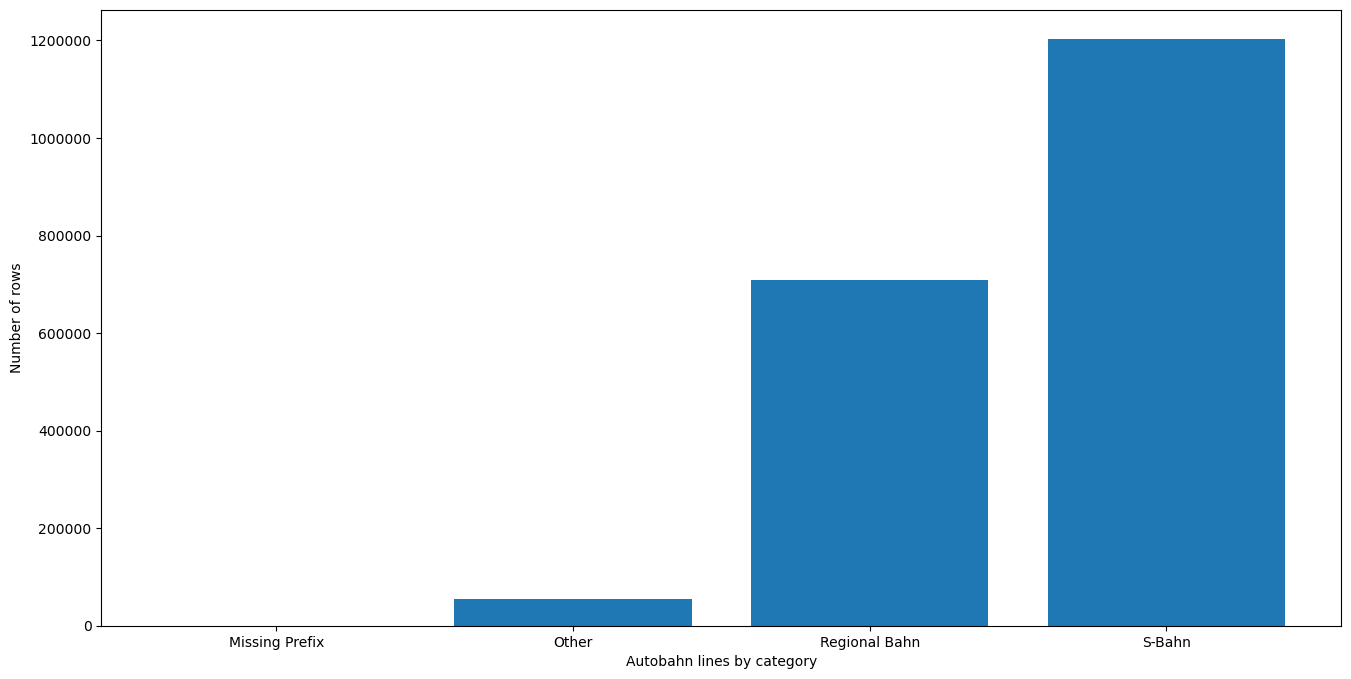

In [38]:
lines = data['line'].dropna().astype(str)
def classify_line(line):
    if pd.isna(line):
        return None
    line = str(line).upper().strip()

    if re.match(r'^(RE|IRE|RB|RS|C)', line):
        return 'Regional Bahn'
    elif re.match(r'^S', line):
        return 'S-Bahn'
    elif re.match(r'^\d+[A-Z]?$' , line):  # e.g. 10, 10B, 25A
        return 'Missing Prefix'
    else:
        return 'Other'

classified = lines.apply(classify_line)
counts = classified.value_counts().sort_index()

plt.figure(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')
plt.bar(counts.index, counts.values)
plt.xlabel("Autobahn lines by category")
plt.ylabel("Number of rows")
plt.show()

Checking what values are classified as other

In [40]:
unknown_lines = lines[classified == 'Other'].unique()
print(unknown_lines)

['EV' 'MEX17A' 'MEX13' '3S3' 'N3' 'EV22A' 'EM24' 'FLX30' 'MEX16' 'A3'
 'MEX12' 'U28' 'RT1' 'L7' 'RJX62' 'A2' 'MEX19' 'FLX35' 'FLX20' 'MEX18'
 'RNV3' 'Biker' 'N14' 'MEX' 'X85F' 'T9' 'FEX' 'WX' 'EX']


Dropping rows with line 'Biker'

In [74]:
data = data[data['line'] != 'Biker'] #22 rows had line Biker

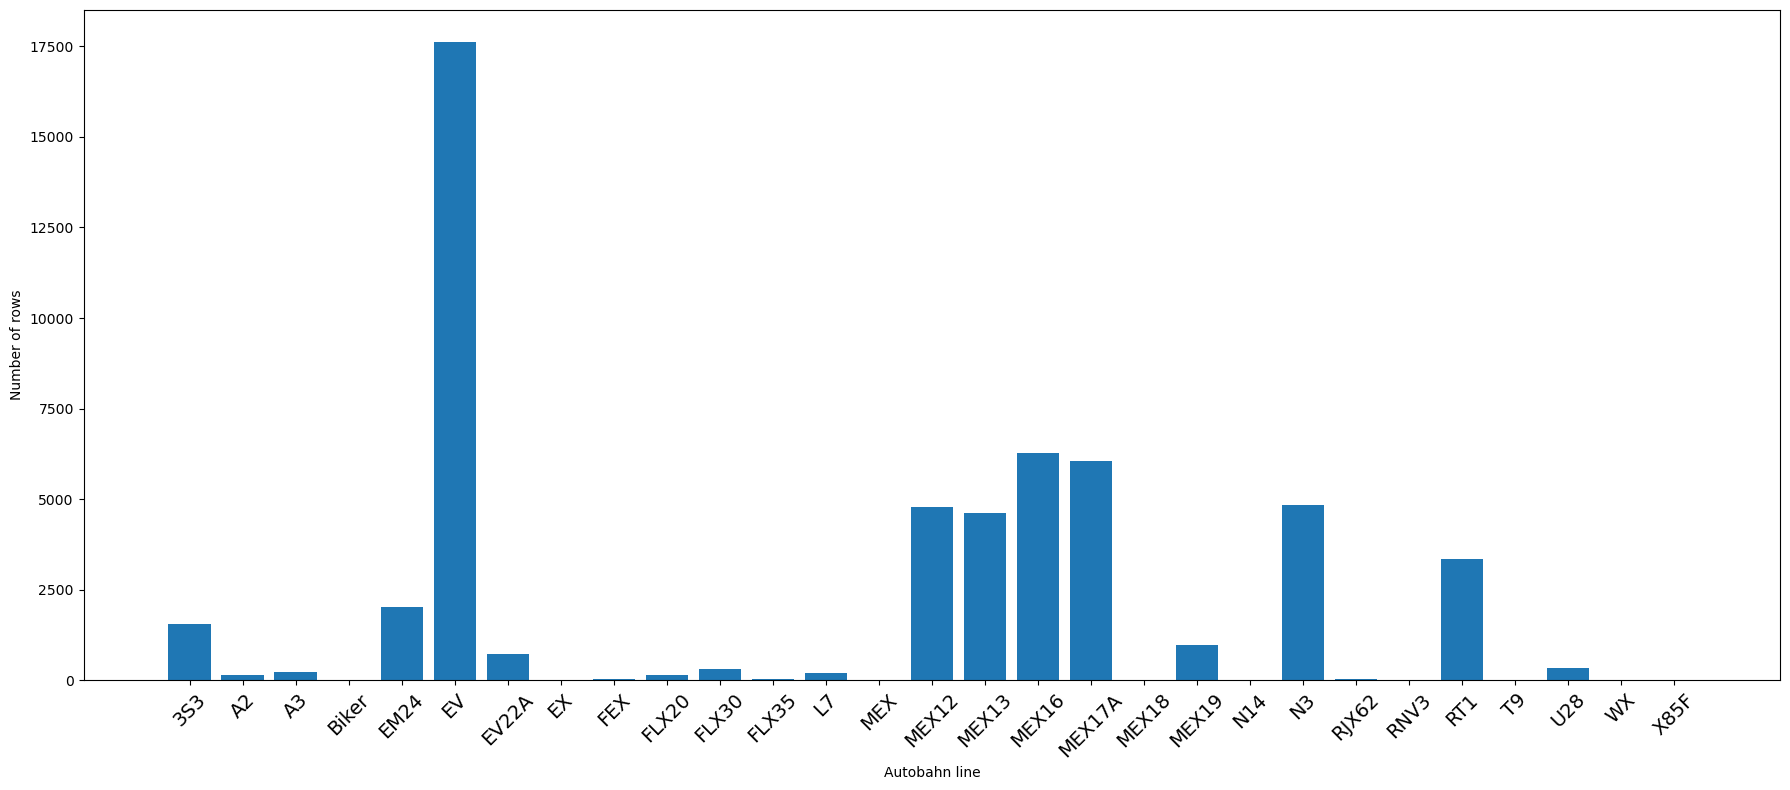

In [75]:
counts = lines[classified == 'Other'].value_counts().sort_index()
plt.figure(figsize=(18,8))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=14)
plt.xlim(-2, len(counts.index) + 1) 
plt.tight_layout()
plt.show()

Regional line RE

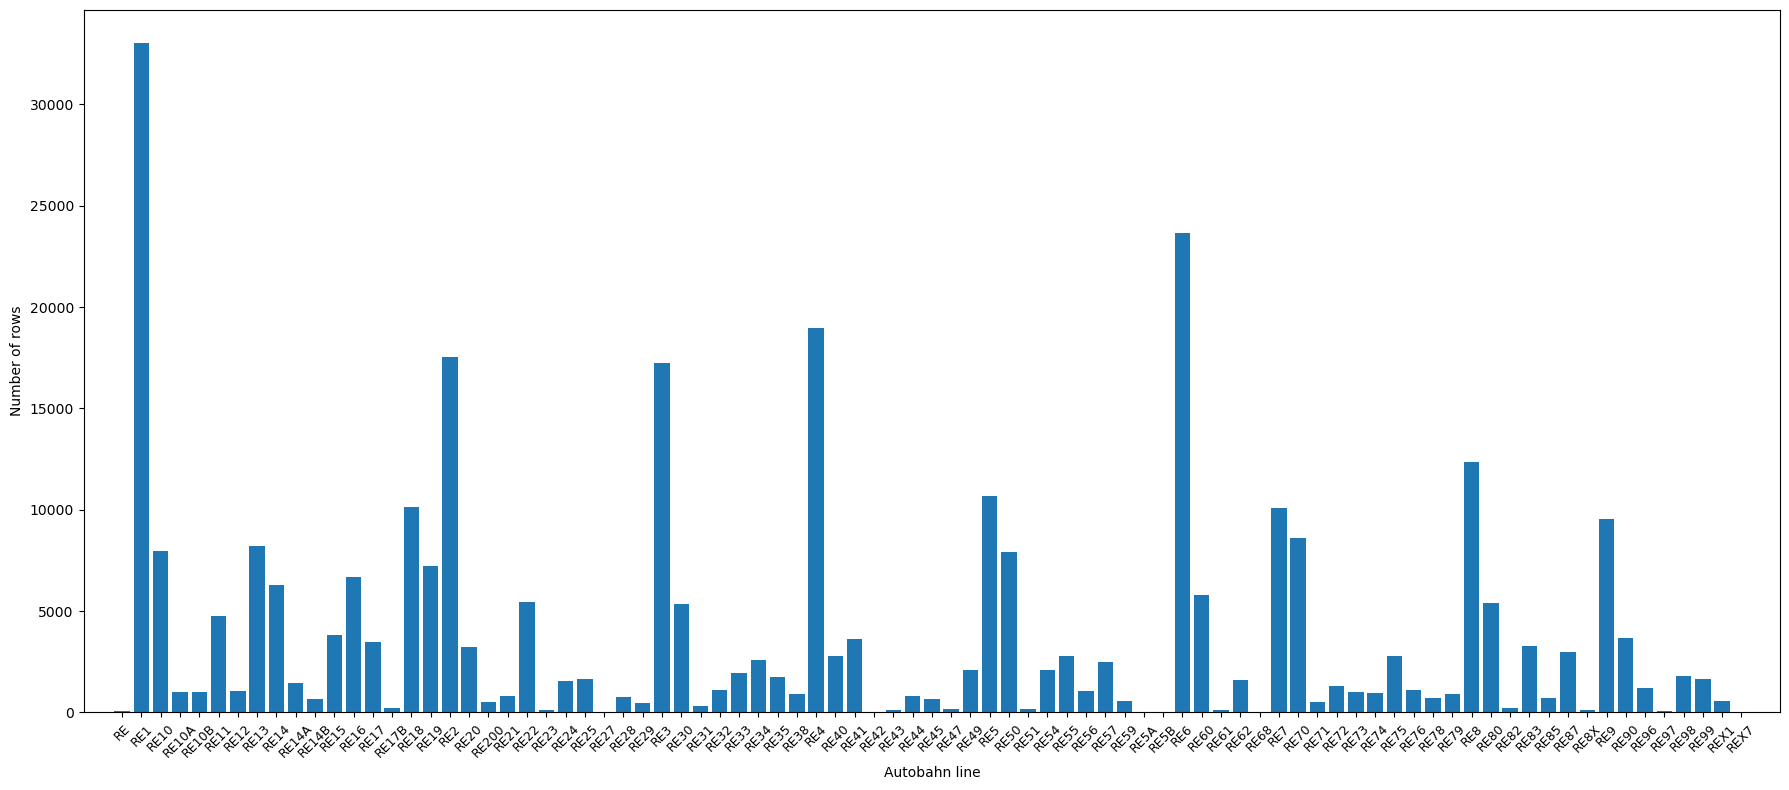

In [76]:

regional = lines[classified == 'Regional Bahn']
regional_re = regional[regional.str.startswith('RE')].value_counts().sort_index()

plt.figure(figsize=(18,8))
plt.bar(regional_re.index.astype(str), regional_re.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=9)
plt.xlim(-2, len(regional_re.index) + 1) 
plt.tight_layout()
plt.show()

Regional line RB

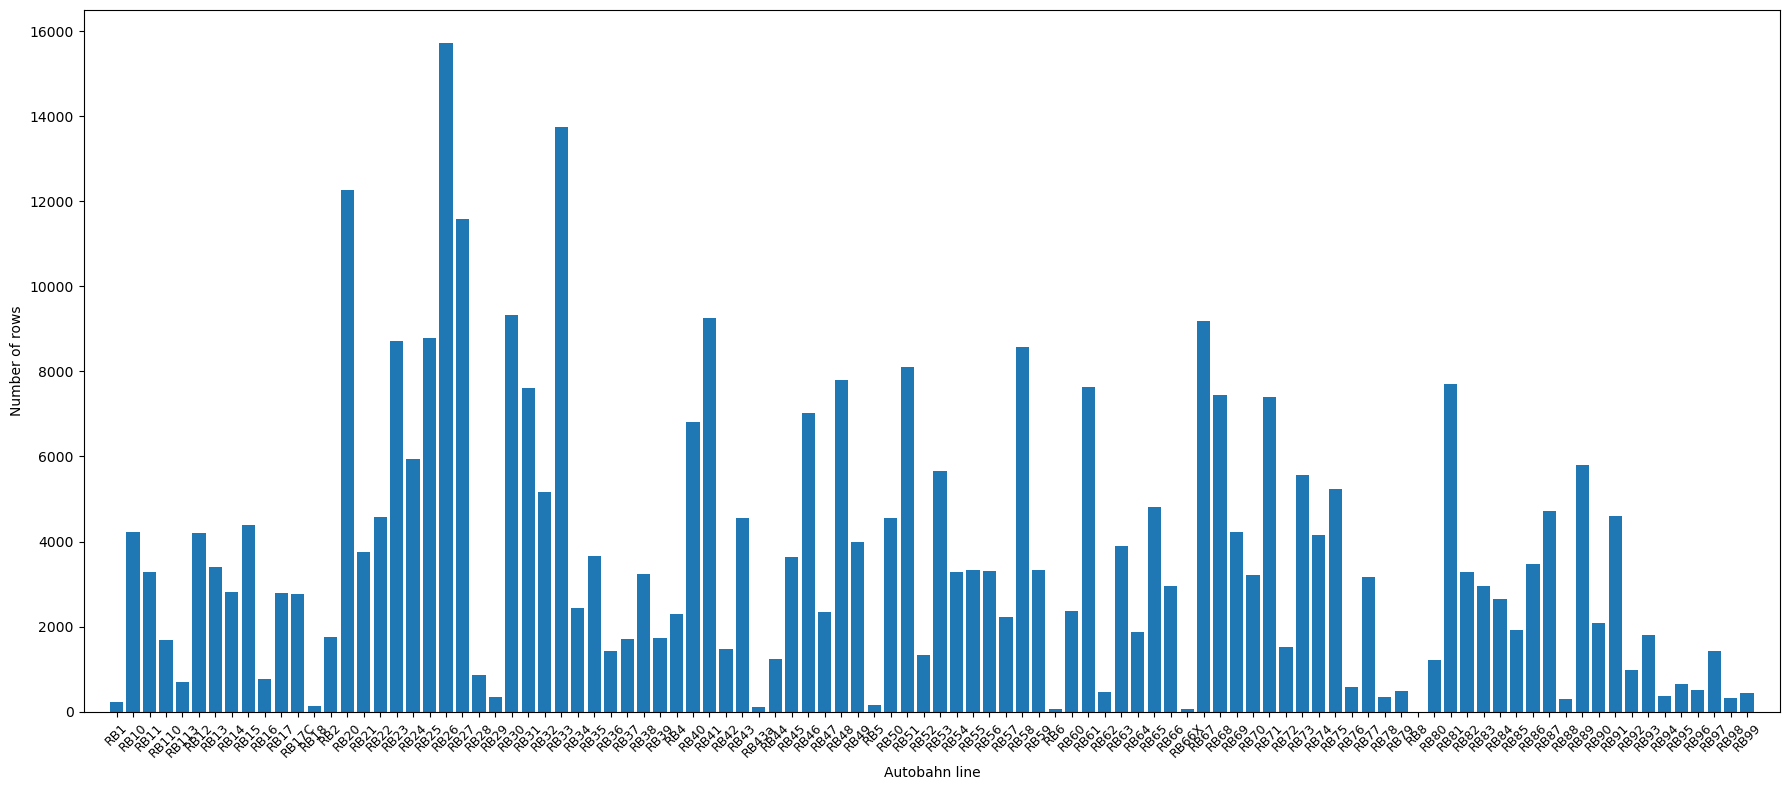

In [77]:
regional_rb = regional[regional.str.startswith('RB')].value_counts().sort_index()

plt.figure(figsize=(18,8))
plt.bar(regional_rb.index.astype(str), regional_rb.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=9)
plt.xlim(-2, len(regional_rb.index) + 1) 
plt.tight_layout()
plt.show()

Regional lines RS and C

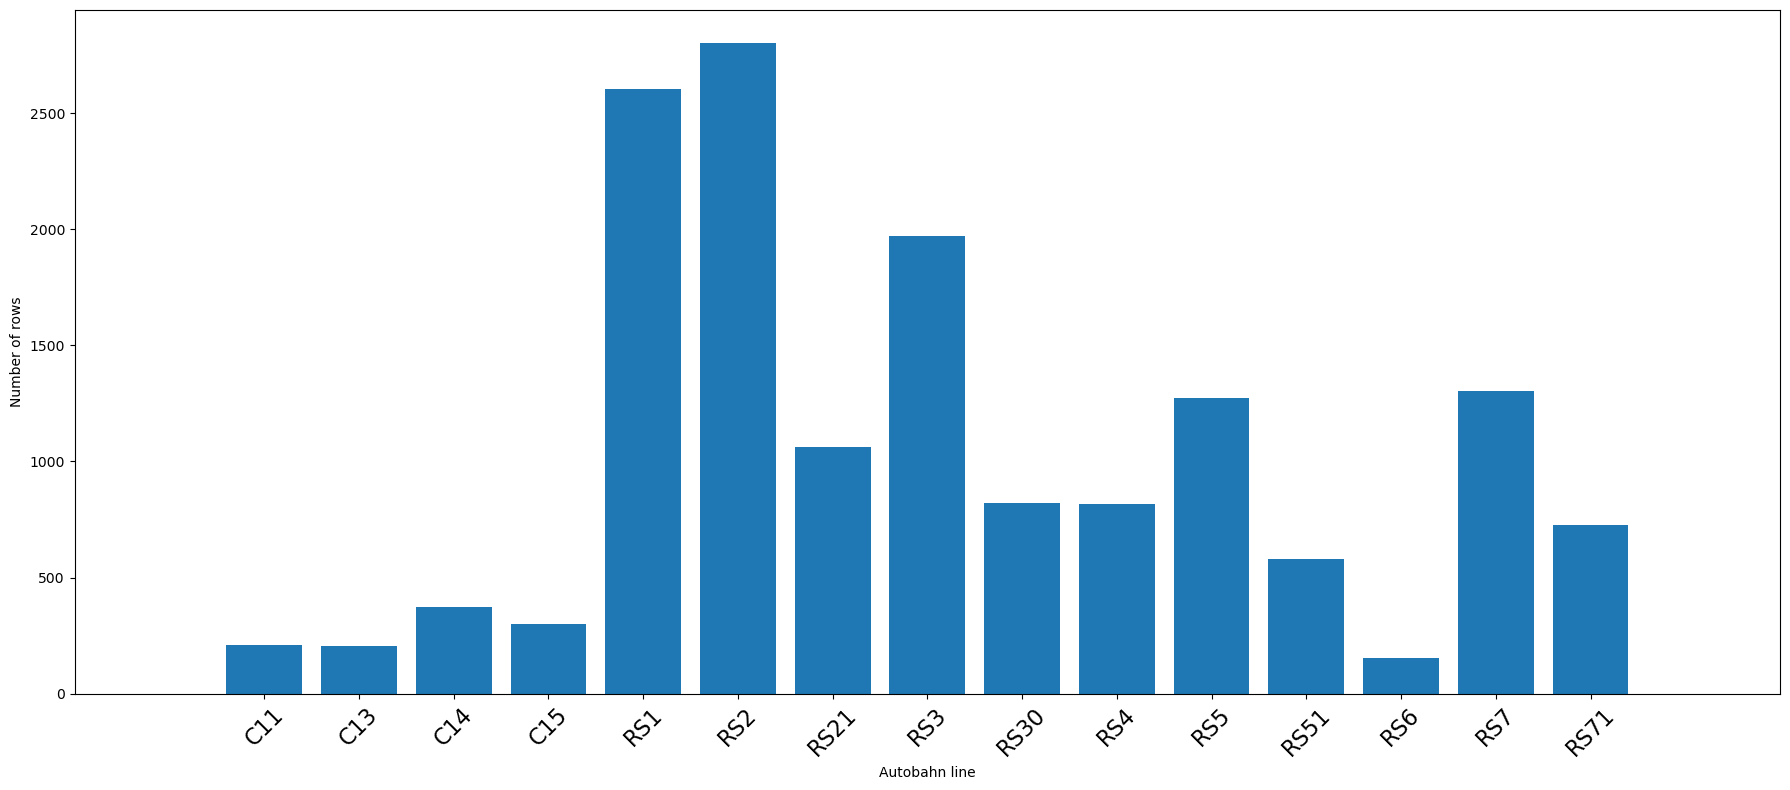

In [78]:
regional_rs_c = regional[regional.str.startswith(('RS', 'C'))].value_counts().sort_index()

plt.figure(figsize=(18,8))
plt.bar(regional_rs_c.index.astype(str), regional_rs_c.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=16)
plt.xlim(-2, len(regional_rs_c.index) + 1) 
plt.tight_layout()
plt.show()

S-Bahn lines

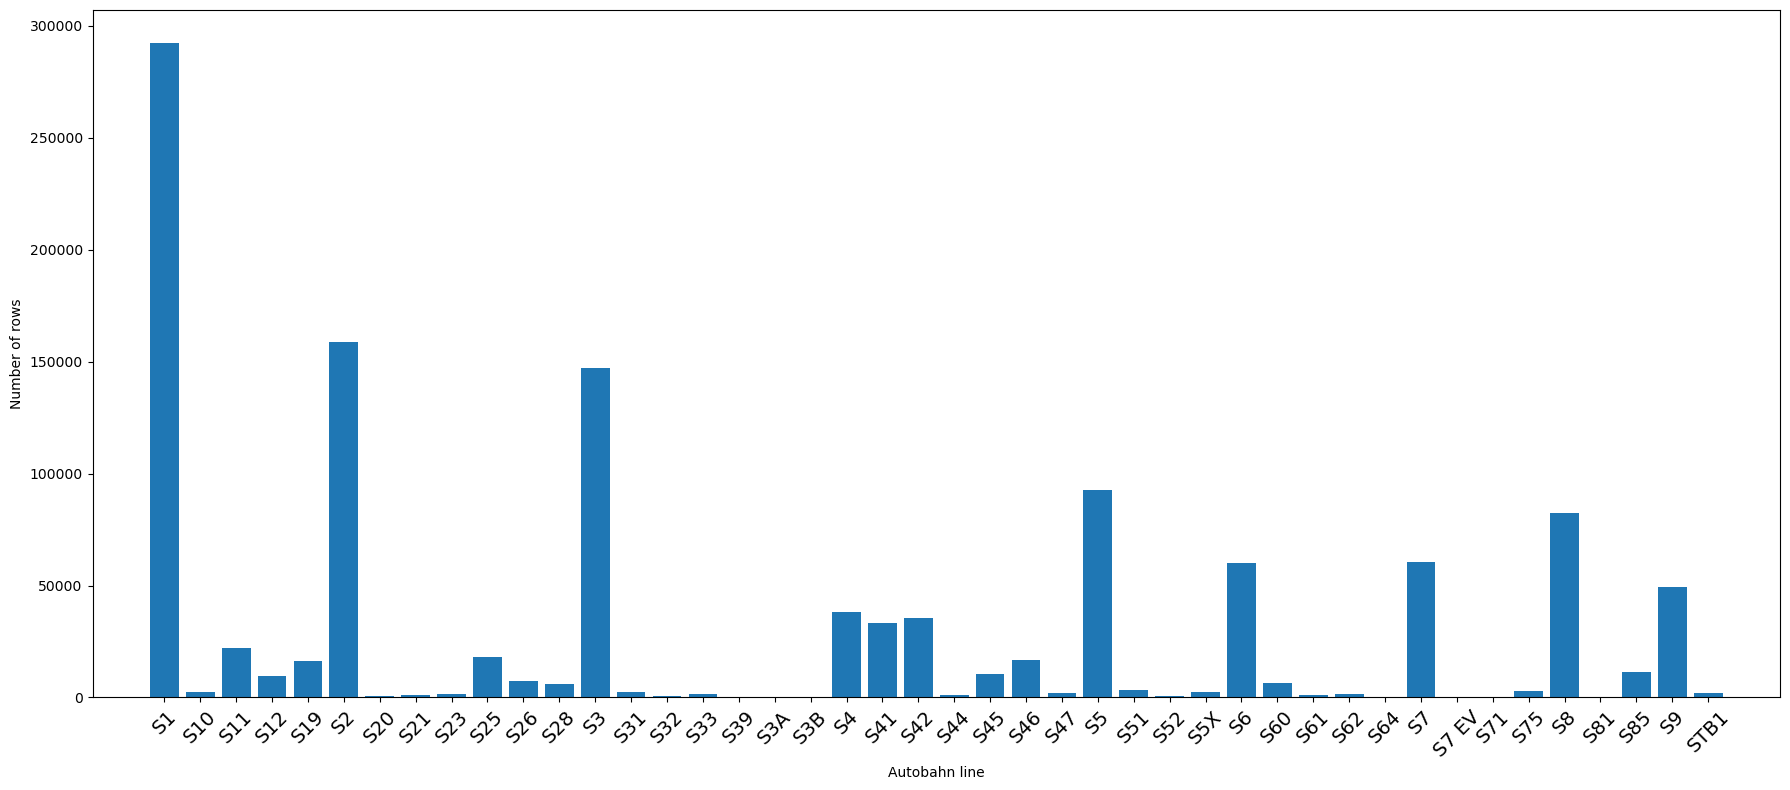

In [79]:
counts = lines[classified == 'S-Bahn'].value_counts().sort_index()
plt.figure(figsize=(18,8))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=14)
plt.xlim(-2, len(counts.index) + 1) 
plt.tight_layout()
plt.show()

## Other visualizations

In [ ]:
def get_path_list(path):
    if pd.isna(path) or path.strip() == '':
        return []
    return path.split('|')

#list of all the stations 
#mb should overwrite path column instead of creating new?
data['path_list'] = data['path'].apply(get_path_list)

In [ ]:
#number of stops
data['num_stops'] = data['path_list'].apply(len)

Changing line type to category

In [82]:
data['line'] = data['line'].astype('category')